
# <center>Approximate Quantum Compiling</center>

<center>Albert Akhriev and Anton Dekusar <br> IBM Research Ireland, 2023 </center>

## Introduction

Approximate Quantum Compiling (``AQC``) is a technique in quantum circuit design that aims to create approximate quantum circuits for a given quantum algorithm using *classical* optimization. In the context of this module, "quantum algorithm" means a target unitary matrix that implements the action of algorithm. Please, refer to the papers [[1], [2], [3]](#references) and the notebook named ``problem_and_ansatz.ipynb`` for more precise problem formulation. Here we just re-state some formulations, assumptions, notions, etc. that would be used in this presentation:

1. The *full AQC* approach solves the following problem [[2]](#references):
$$
\Theta^* = \arg \min_{\Theta} \left( 1 - \frac{1}{d} \text{Re} \left\langle V(\Theta), \widetilde{U} \right\rangle \right)
,\qquad\qquad\qquad (1)
$$
where the special unitary $(SU(d))$ matrix $\widetilde{U}$ is obtained form the original target one $U$ via multiplication by an appropriate complex unit factor (*global phase*), $V = V(\Theta)$ is a matrix of parametrized ansatz circuit, $\Theta$ is a vector of parameters to be optimized, $d = 2^n$ is the problem dimension and $n$ is the number of qubits. Note, we optimize $V(\Theta)$ against $SU(d)$ matrix $\widetilde{U}$, which gives a solution from one of the equivalence classes, and augment $V(\Theta)$ by the global phase, see the notebook ``problem_and_ansatz.ipynb``.

2. Slightly different objective is used in coordinate descent method, see below, which in principle does not require conversion of the target matrix into special unitary class:
$$
\Theta^* = \arg \min_{\Theta} \left( 1 - \frac{1}{d^2} \left| \left\langle V(\Theta), \widetilde{U} \right\rangle \right|^2 \right).
\qquad\qquad\qquad (2)
$$

3. *Sketched AQC* method is a variation of the full-space approach (1):
$$
\Theta^* = \arg \min_{\Theta} \left( 
1 - \frac{1}{m}\text{Re} \left\langle V Q, \widetilde{U} Q \right\rangle \right)
,\qquad\qquad\qquad (3)
$$
where we optimize over a sub-space of orthonormal column-vectors of $d \times m$ matrix $Q$, and $m \le d = 2^n$.

4. Ansatz's ``depth`` is the total number of 2-qubit unit-block in a circuit.

#### Module paths

If running this notebook without installation, directly *from the root folder* of the package downloaded from the GitHub, the following ``bash`` snippet helps to resolve module paths:

```
(export PYTHONPATH=`pwd` && echo "Python path: ${PYTHONPATH}" && jupyter notebook docs/aqc.ipynb)
```

## Full AQC, coordinate descent optimization 

In [[2]](#references), Section IV, we outlined the economical way to compute the gradient of objective function. One minor extension would be to compute the gradient component, say $k$-th one, and update the corresponding parameter $\Theta_k$ right before moving to the next $k+1$ gate. Moreover, differentiating the dot-product $\langle V, U \rangle$ twice by $k$-th parameter we obtain the same entity scaled by a constant factor. This happens because for any rotation gate $R = e^{-\frac{i}{2}\Theta_k\sigma}$ we have: $d^2 R / d \Theta^2_k$ = $(-\frac{i}{2}\sigma)^2 R$ = $-\frac{1}{4} R$, cf. [[2]](#references), end of Section IV.

Let us define a short-hand notation for the dot-product $p := \langle V, U \rangle$ and its gradient by $k$-th parameter ${\partial p}/{\partial \Theta_k} = \frac{i}{2} \langle V_{aug}, U \rangle$, where $V_{aug}$ is the ansatz circuit augmented by a single Pauli gate next to $k$-th rotation gate as detailed in [[2]](#references), Section IV. It is straightforward to show that ${\partial^2 p}/{\partial \Theta_k^2} = -\frac{1}{4} p$. Ultimately, after simple calculations, we have for the objective (2):
$$
f(\Theta) = 1 - \frac{1}{d^2} \left| \left\langle V, U \right\rangle \right|^2 = 1 - \frac{|p|^2}{d^2},
$$
$$
f^{\prime}_k := \frac{\partial f}{\partial \Theta_k} = -\frac{2}{d^2} \text{Re} 
\left( \overline{p} \, \frac{\partial p}{\partial \Theta_k} \right)
$$
$$
f^{\prime\prime}_k := \frac{\partial^2 f}{\partial \Theta_k^2} = \frac{1}{2 d^2} \left| p \right|^2 
- \frac{2}{d^2} \left| \frac{\partial p}{\partial \Theta_k} \right|^2
$$

As we progressing in gradient computation gate by gate (according to the algorithm described in [[2]](#references)), the $\Theta$ parameters are being updated by either a single Newton iteration, $\Delta\Theta_k = -f^{\prime}_k / f^{\prime\prime}_k$, if the 2nd derivative is strictly positive $f^{\prime\prime}_k > 0$, or by a single step of gradient descent, $\Delta\Theta_k = -\gamma f^{\prime}_k$ otherwise.

We call a ``sweep`` the single pass over all the parameters $\Theta$. Every sweep makes up a single (big) iteration in optimization routine. In order to find a good solution, we run many simulations in parallel with random initial guesses and pick up the best one with the smallest objective function value (and the largest fidelity). Actually, the results of all parallel simulations are reported at the end, and they are ranked by the closeness between the ansatz $V$ and the target $U$.

In contrast to the conventional coordinate descent, we cannot update parameters in random order because that would break up the back-propagation algorithm given in [[2]](#references). Despite that, the approach demonstrates good convergence for a moderate number of qubits. 

### Experiment 1: coordinate descent with randomly generated target

Random target matrices are particularly difficult to approximate because they typically adds a strong entanglement to a state they act on. One should not expect a short approximating ansatz achieves a good fidelity. In [[1],[2]] we mentioned that in general case the circuit length should be $L \ge \frac{1}{4}(4^n - 3n - 1)$ in order to be exactly compiled. This is a very pessimistic lower bound, although many useful circuits can be approximated by a shallow ansatz. In the example below, we set the circuit depth as a fraction of $L$ when randomly generated target $U$ is used.

The code below repeats the functionality of the script ``run_aqc_coord_descent.py``. At the end of optimization it will print out the path where all useful artefacts have been saved on. That is, the quantum circuit obtained from the best ansatz, the script ``aqc_coordinate_descent.py`` and packed results of all parallel simulations ranked in decreasing approximation accuracy. In addition, if one uses the script ``run_aqc_coord_descent.py`` directly, it will save itself in the result directory so that the outcome of experiment can be reproduced (except the ``seed`` value unless it is hardcoded). 

In [1]:
import os
import traceback
import time
from aqc_research.circuit_structures import fraction_of_lower_bound
import aqc_research.utils as helper
from aqc_research.model_sketching.aqc_coord_descent import aqc_coordinate_descent

def experiment1():
    tic = time.perf_counter()
    try:
        circuit_layout = "cyclic_spin"
        num_qubits = 5
        num_layers = fraction_of_lower_bound(0.7, num_qubits, circuit_layout)
        # num_layers = num_qubits ** 2,  # explicit number of layers
        aqc_coordinate_descent(
            num_qubits=num_qubits,
            num_layers=num_layers,
            circ_layout=circuit_layout,
            maxiter=1000,  # number of "sweeps" over all the parameters
            target_name_or_func="random",
            result_folder=os.path.join(os.getcwd(), "results", "aqc_coord_descent"),
            seed=int(round(time.time())),
            time_limit=-1,
            num_simulations=helper.num_cpus(),
            num_jobs=helper.num_cpus(),
            tag="notebook",
            logger=helper.create_logger("notebook"),
        )
        print("finished normally")
    except Exception:
        print(f"\n{traceback.format_exc()}\n")
    finally:
        print(f"Total execution time: {(time.perf_counter() - tic):0.2f}")

experiment1()

2023-05-04 19:59:40 | notebook | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'circ_layout': 'cyclic_spin',
 'maxiter': 1000,
 'num_jobs': 12,
 'num_layers': 36,
 'num_qubits': 5,
 'num_simulations': 12,
 'parametric_depth': 3,
 'result_folder': '/private/tmp/aqc-research/docs/results/aqc_coord_descent/5qubits/2023-05-04_19.59.40_notebook',
 'seed': 1683226780,
 'tag': 'notebook',
 'target_name_or_func': 'random',
 'time_limit': -1}
--------------------------------------------------------------------------------

2023-05-04 19:59:40 | notebook | info | target: random
2023-05-04 19:59:40 | target_generator.py | info | generates target unitary from a random matrix
2023-05-04 19:59:40 | target_generator.py | info | Target matrix has been prepared in 0.00 secs
2023-05-04 19:59:40 | notebook | info | target has been created in  0.002 secs
2023-05-04 19:59:40

2023-05-04 20:00:04 | job_0 | info | iter:   85, fobj: 0.0792, |dtheta|: 0.00507
2023-05-04 20:00:05 | job_0 | info | iter:   86, fobj: 0.0789, |dtheta|: 0.00498
2023-05-04 20:00:05 | job_0 | info | iter:   87, fobj: 0.0786, |dtheta|: 0.00487
2023-05-04 20:00:05 | job_0 | info | iter:   88, fobj: 0.0783, |dtheta|: 0.00477
2023-05-04 20:00:05 | job_0 | info | iter:   89, fobj: 0.0780, |dtheta|: 0.00465
2023-05-04 20:00:06 | job_0 | info | iter:   90, fobj: 0.0778, |dtheta|: 0.00453
2023-05-04 20:00:06 | job_0 | info | iter:   91, fobj: 0.0775, |dtheta|: 0.00440
2023-05-04 20:00:06 | job_0 | info | iter:   92, fobj: 0.0772, |dtheta|: 0.00431
2023-05-04 20:00:06 | job_0 | info | iter:   93, fobj: 0.0769, |dtheta|: 0.00439
2023-05-04 20:00:07 | job_0 | info | iter:   94, fobj: 0.0767, |dtheta|: 0.00449
2023-05-04 20:00:07 | job_0 | info | iter:   95, fobj: 0.0764, |dtheta|: 0.00460
2023-05-04 20:00:07 | job_0 | info | iter:   96, fobj: 0.0761, |dtheta|: 0.00470
2023-05-04 20:00:08 | job_0 

2023-05-04 20:00:34 | job_0 | info | iter:  187, fobj: 0.0605, |dtheta|: 0.00296
2023-05-04 20:00:34 | job_0 | info | iter:  188, fobj: 0.0604, |dtheta|: 0.00291
2023-05-04 20:00:34 | job_0 | info | iter:  189, fobj: 0.0603, |dtheta|: 0.00286
2023-05-04 20:00:35 | job_0 | info | iter:  190, fobj: 0.0602, |dtheta|: 0.00281
2023-05-04 20:00:35 | job_0 | info | iter:  191, fobj: 0.0602, |dtheta|: 0.00276
2023-05-04 20:00:35 | job_0 | info | iter:  192, fobj: 0.0601, |dtheta|: 0.00271
2023-05-04 20:00:35 | job_0 | info | iter:  193, fobj: 0.0600, |dtheta|: 0.00269
2023-05-04 20:00:36 | job_0 | info | iter:  194, fobj: 0.0599, |dtheta|: 0.00268
2023-05-04 20:00:36 | job_0 | info | iter:  195, fobj: 0.0598, |dtheta|: 0.00267
2023-05-04 20:00:36 | job_0 | info | iter:  196, fobj: 0.0598, |dtheta|: 0.00266
2023-05-04 20:00:37 | job_0 | info | iter:  197, fobj: 0.0597, |dtheta|: 0.00264
2023-05-04 20:00:37 | job_0 | info | iter:  198, fobj: 0.0596, |dtheta|: 0.00263
2023-05-04 20:00:37 | job_0 

2023-05-04 20:01:01 | job_0 | info | iter:  289, fobj: 0.0560, |dtheta|: 0.00262
2023-05-04 20:01:02 | job_0 | info | iter:  290, fobj: 0.0560, |dtheta|: 0.00262
2023-05-04 20:01:02 | job_0 | info | iter:  291, fobj: 0.0559, |dtheta|: 0.00262
2023-05-04 20:01:02 | job_0 | info | iter:  292, fobj: 0.0559, |dtheta|: 0.00262
2023-05-04 20:01:02 | job_0 | info | iter:  293, fobj: 0.0559, |dtheta|: 0.00261
2023-05-04 20:01:03 | job_0 | info | iter:  294, fobj: 0.0559, |dtheta|: 0.00261
2023-05-04 20:01:03 | job_0 | info | iter:  295, fobj: 0.0558, |dtheta|: 0.00261
2023-05-04 20:01:03 | job_0 | info | iter:  296, fobj: 0.0558, |dtheta|: 0.00261
2023-05-04 20:01:03 | job_0 | info | iter:  297, fobj: 0.0558, |dtheta|: 0.00260
2023-05-04 20:01:04 | job_0 | info | iter:  298, fobj: 0.0558, |dtheta|: 0.00260
2023-05-04 20:01:04 | job_0 | info | iter:  299, fobj: 0.0557, |dtheta|: 0.00260
2023-05-04 20:01:04 | job_0 | info | iter:  300, fobj: 0.0557, |dtheta|: 0.00259
2023-05-04 20:01:04 | job_0 

2023-05-04 20:01:29 | job_0 | info | iter:  391, fobj: 0.0534, |dtheta|: 0.00211
2023-05-04 20:01:29 | job_0 | info | iter:  392, fobj: 0.0534, |dtheta|: 0.00210
2023-05-04 20:01:29 | job_0 | info | iter:  393, fobj: 0.0534, |dtheta|: 0.00210
2023-05-04 20:01:30 | job_0 | info | iter:  394, fobj: 0.0533, |dtheta|: 0.00209
2023-05-04 20:01:30 | job_0 | info | iter:  395, fobj: 0.0533, |dtheta|: 0.00209
2023-05-04 20:01:30 | job_0 | info | iter:  396, fobj: 0.0533, |dtheta|: 0.00208
2023-05-04 20:01:30 | job_0 | info | iter:  397, fobj: 0.0532, |dtheta|: 0.00208
2023-05-04 20:01:31 | job_0 | info | iter:  398, fobj: 0.0532, |dtheta|: 0.00207
2023-05-04 20:01:31 | job_0 | info | iter:  399, fobj: 0.0532, |dtheta|: 0.00207
2023-05-04 20:01:31 | job_0 | info | iter:  400, fobj: 0.0531, |dtheta|: 0.00206
2023-05-04 20:01:32 | job_0 | info | iter:  401, fobj: 0.0531, |dtheta|: 0.00206
2023-05-04 20:01:32 | job_0 | info | iter:  402, fobj: 0.0531, |dtheta|: 0.00205
2023-05-04 20:01:32 | job_0 

2023-05-04 20:01:57 | job_0 | info | iter:  493, fobj: 0.0496, |dtheta|: 0.00206
2023-05-04 20:01:57 | job_0 | info | iter:  494, fobj: 0.0496, |dtheta|: 0.00206
2023-05-04 20:01:57 | job_0 | info | iter:  495, fobj: 0.0496, |dtheta|: 0.00206
2023-05-04 20:01:58 | job_0 | info | iter:  496, fobj: 0.0495, |dtheta|: 0.00206
2023-05-04 20:01:58 | job_0 | info | iter:  497, fobj: 0.0495, |dtheta|: 0.00207
2023-05-04 20:01:58 | job_0 | info | iter:  498, fobj: 0.0495, |dtheta|: 0.00207
2023-05-04 20:01:58 | job_0 | info | iter:  499, fobj: 0.0494, |dtheta|: 0.00207
2023-05-04 20:01:59 | job_0 | info | iter:  500, fobj: 0.0494, |dtheta|: 0.00206
2023-05-04 20:01:59 | job_0 | info | iter:  501, fobj: 0.0494, |dtheta|: 0.00206
2023-05-04 20:01:59 | job_0 | info | iter:  502, fobj: 0.0493, |dtheta|: 0.00206
2023-05-04 20:01:59 | job_0 | info | iter:  503, fobj: 0.0493, |dtheta|: 0.00206
2023-05-04 20:02:00 | job_0 | info | iter:  504, fobj: 0.0493, |dtheta|: 0.00206
2023-05-04 20:02:00 | job_0 

2023-05-04 20:02:23 | job_0 | info | iter:  595, fobj: 0.0472, |dtheta|: 0.00182
2023-05-04 20:02:23 | job_0 | info | iter:  596, fobj: 0.0472, |dtheta|: 0.00182
2023-05-04 20:02:24 | job_0 | info | iter:  597, fobj: 0.0472, |dtheta|: 0.00182
2023-05-04 20:02:24 | job_0 | info | iter:  598, fobj: 0.0472, |dtheta|: 0.00182
2023-05-04 20:02:24 | job_0 | info | iter:  599, fobj: 0.0472, |dtheta|: 0.00181
2023-05-04 20:02:24 | job_0 | info | iter:  600, fobj: 0.0471, |dtheta|: 0.00181
2023-05-04 20:02:25 | job_0 | info | iter:  601, fobj: 0.0471, |dtheta|: 0.00181
2023-05-04 20:02:25 | job_0 | info | iter:  602, fobj: 0.0471, |dtheta|: 0.00180
2023-05-04 20:02:25 | job_0 | info | iter:  603, fobj: 0.0471, |dtheta|: 0.00180
2023-05-04 20:02:25 | job_0 | info | iter:  604, fobj: 0.0471, |dtheta|: 0.00180
2023-05-04 20:02:26 | job_0 | info | iter:  605, fobj: 0.0471, |dtheta|: 0.00180
2023-05-04 20:02:26 | job_0 | info | iter:  606, fobj: 0.0470, |dtheta|: 0.00179
2023-05-04 20:02:26 | job_0 

2023-05-04 20:02:50 | job_0 | info | iter:  697, fobj: 0.0458, |dtheta|: 0.00153
2023-05-04 20:02:50 | job_0 | info | iter:  698, fobj: 0.0458, |dtheta|: 0.00152
2023-05-04 20:02:51 | job_0 | info | iter:  699, fobj: 0.0458, |dtheta|: 0.00152
2023-05-04 20:02:51 | job_0 | info | iter:  700, fobj: 0.0458, |dtheta|: 0.00152
2023-05-04 20:02:51 | job_0 | info | iter:  701, fobj: 0.0457, |dtheta|: 0.00152
2023-05-04 20:02:51 | job_0 | info | iter:  702, fobj: 0.0457, |dtheta|: 0.00151
2023-05-04 20:02:52 | job_0 | info | iter:  703, fobj: 0.0457, |dtheta|: 0.00151
2023-05-04 20:02:52 | job_0 | info | iter:  704, fobj: 0.0457, |dtheta|: 0.00151
2023-05-04 20:02:52 | job_0 | info | iter:  705, fobj: 0.0457, |dtheta|: 0.00150
2023-05-04 20:02:53 | job_0 | info | iter:  706, fobj: 0.0457, |dtheta|: 0.00150
2023-05-04 20:02:53 | job_0 | info | iter:  707, fobj: 0.0457, |dtheta|: 0.00150
2023-05-04 20:02:53 | job_0 | info | iter:  708, fobj: 0.0457, |dtheta|: 0.00150
2023-05-04 20:02:53 | job_0 

2023-05-04 20:03:18 | job_0 | info | iter:  799, fobj: 0.0445, |dtheta|: 0.00199
2023-05-04 20:03:18 | job_0 | info | iter:  800, fobj: 0.0445, |dtheta|: 0.00200
2023-05-04 20:03:19 | job_0 | info | iter:  801, fobj: 0.0445, |dtheta|: 0.00201
2023-05-04 20:03:19 | job_0 | info | iter:  802, fobj: 0.0445, |dtheta|: 0.00201
2023-05-04 20:03:19 | job_0 | info | iter:  803, fobj: 0.0444, |dtheta|: 0.00202
2023-05-04 20:03:20 | job_0 | info | iter:  804, fobj: 0.0444, |dtheta|: 0.00203
2023-05-04 20:03:20 | job_0 | info | iter:  805, fobj: 0.0444, |dtheta|: 0.00204
2023-05-04 20:03:20 | job_0 | info | iter:  806, fobj: 0.0444, |dtheta|: 0.00205
2023-05-04 20:03:20 | job_0 | info | iter:  807, fobj: 0.0444, |dtheta|: 0.00205
2023-05-04 20:03:21 | job_0 | info | iter:  808, fobj: 0.0444, |dtheta|: 0.00206
2023-05-04 20:03:21 | job_0 | info | iter:  809, fobj: 0.0444, |dtheta|: 0.00207
2023-05-04 20:03:21 | job_0 | info | iter:  810, fobj: 0.0443, |dtheta|: 0.00207
2023-05-04 20:03:21 | job_0 

2023-05-04 20:03:46 | job_0 | info | iter:  901, fobj: 0.0429, |dtheta|: 0.00156
2023-05-04 20:03:46 | job_0 | info | iter:  902, fobj: 0.0429, |dtheta|: 0.00155
2023-05-04 20:03:47 | job_0 | info | iter:  903, fobj: 0.0429, |dtheta|: 0.00153
2023-05-04 20:03:47 | job_0 | info | iter:  904, fobj: 0.0428, |dtheta|: 0.00152
2023-05-04 20:03:47 | job_0 | info | iter:  905, fobj: 0.0428, |dtheta|: 0.00150
2023-05-04 20:03:47 | job_0 | info | iter:  906, fobj: 0.0428, |dtheta|: 0.00149
2023-05-04 20:03:48 | job_0 | info | iter:  907, fobj: 0.0428, |dtheta|: 0.00147
2023-05-04 20:03:48 | job_0 | info | iter:  908, fobj: 0.0428, |dtheta|: 0.00146
2023-05-04 20:03:48 | job_0 | info | iter:  909, fobj: 0.0428, |dtheta|: 0.00144
2023-05-04 20:03:48 | job_0 | info | iter:  910, fobj: 0.0427, |dtheta|: 0.00143
2023-05-04 20:03:49 | job_0 | info | iter:  911, fobj: 0.0427, |dtheta|: 0.00141
2023-05-04 20:03:49 | job_0 | info | iter:  912, fobj: 0.0427, |dtheta|: 0.00140
2023-05-04 20:03:49 | job_0 

2023-05-04 20:04:13 | notebook | info | generating the best quantum circuit and its matrix ...
2023-05-04 20:04:13 | notebook | info | done in 0.0597 seconds

2023-05-04 20:04:13 | notebook | info | computing the global phase ...
2023-05-04 20:04:13 | notebook | info | done in 0.0001 seconds
2023-05-04 20:04:13 | notebook | info | global phase factor (angle): 1.416571

2023-05-04 20:04:13 | notebook | info | computing approximation accuracy ...
2023-05-04 20:04:13 | notebook | info | done in 0.0209 seconds

2023-05-04 20:04:13 | notebook | info | Approximation accuracy for best result and full matrices:
2023-05-04 20:04:13 | notebook | info | HS-cost = 1 - |<V,U>|/dim: 0.01837767
2023-05-04 20:04:13 | notebook | info | Fidelity: 0.96468597
2023-05-04 20:04:13 | notebook | info | Max. singular value of (V - U): 0.31714467
2023-05-04 20:04:13 | notebook | info | Largest sing.values of (V - U): [0.317 0.295 0.273 0.252 0.242 0.222 0.21  0.198 0.186 0.178]
2023-05-04 20:04:13 | notebook | 

## Full AQC, quasi-Newton optimization 

Here we minimize the full-AQC objective function using the quasi-Newton algorithm such as ``L-BFGS``:
$$
f(\Theta) = 1 - \frac{1}{2^n}\text{Re} \left\langle V, \widetilde{U} \right\rangle
$$
The "full-AQC" in this context means we are going to approximate the target matrix $\widetilde{U}$ and optimization is done over the entire Hilbert space $C^d$, where $d = 2^n$ and $n$ is the number of qubits.

In the code below, the same package is used as for the sketching method, which will be described next. It repeats the functionality of ``run_aqc_sketching.py`` Python script. Similarly to coordinate descent approach, all useful artefacts will be saved on on the path printed at the end of optimization. That is, the quantum circuit obtained from the best ansatz, the script ``aqc_sketching.py`` and packed results of all parallel simulations ranked in decreasing approximation accuracy. In addition, if one uses the script ``run_aqc_sketching.py`` directly, it will save itself in the result directory so that the outcome of experiment can be reproduced (except the ``seed`` value unless it is hardcoded).

Like in the previous experiment, we run many simulations in parallel with random initial guesses and sort the results by the value of objective function in the ascending order. In order to see the progress of optimization, the objective value and gradient norm are printed out for the first parallel job.

### Experiment 2: full AQC with randomly generated target

In [2]:
import os
import traceback
import time
from aqc_research.circuit_structures import fraction_of_lower_bound
import aqc_research.utils as helper
from aqc_research.model_sketching.aqc_sketching import aqc_sketching

def experiment2():
    tic = time.perf_counter()
    try:
        circuit_layout = "cyclic_spin"
        num_qubits = 5
        num_layers = fraction_of_lower_bound(0.7, num_qubits, circuit_layout)
        # num_layers = num_qubits ** 2,  # explicit number of layers
        dim = 2**num_qubits
        aqc_sketching(
            num_qubits=num_qubits,
            num_layers=num_layers,
            num_skvecs=dim,  # entire Hilbert space
            circ_layout=circuit_layout,
            maxiter=1000,
            learn_rate=0.025,  # ignored in full AQC
            skvecs_type="full",  # entire Hilbert space
            target_name_or_func="random",
            result_folder=os.path.join(os.getcwd(), "results", "aqc_full"),
            seed=int(round(time.time())),
            time_limit=int(-1),
            num_simulations=helper.num_cpus(),
            num_jobs=helper.num_cpus(),
            tag="notebook",
            logger=helper.create_logger("notebook"),
        )
        print("finished normally")
    except Exception:
        print(f"\n{traceback.format_exc()}\n")
    finally:
        print(f"Total execution time: {(time.perf_counter() - tic):0.2f}")

experiment2()

2023-05-04 20:04:13 | notebook | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'circ_layout': 'cyclic_spin',
 'learn_rate': 0.025,
 'maxiter': 1000,
 'num_jobs': 12,
 'num_layers': 36,
 'num_qubits': 5,
 'num_simulations': 12,
 'num_skvecs': 32,
 'parametric_depth': 3,
 'result_folder': '/private/tmp/aqc-research/docs/results/aqc_full/5qubits/2023-05-04_20.04.13_notebook',
 'seed': 1683227054,
 'skvecs_type': 'full',
 'tag': 'notebook',
 'target_name_or_func': 'random',
 'time_limit': -1}
--------------------------------------------------------------------------------

2023-05-04 20:04:13 | notebook | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'circ_layout': 'cyclic_spin',
 'learn_rate': 0.025,
 'maxiter': 1000,
 'num_j

iter:  270, fobj: 0.0199, |grad|: 0.00289
iter:  271, fobj: 0.0199, |grad|: 0.00202
iter:  272, fobj: 0.0199, |grad|: 0.00178
iter:  273, fobj: 0.0199, |grad|: 0.00252
iter:  274, fobj: 0.0199, |grad|: 0.00186
iter:  275, fobj: 0.0199, |grad|: 0.00180
iter:  276, fobj: 0.0199, |grad|: 0.00286
iter:  277, fobj: 0.0198, |grad|: 0.00211
iter:  278, fobj: 0.0198, |grad|: 0.00191
iter:  279, fobj: 0.0198, |grad|: 0.00270
iter:  280, fobj: 0.0198, |grad|: 0.00205
iter:  281, fobj: 0.0198, |grad|: 0.00219
iter:  282, fobj: 0.0198, |grad|: 0.00344
iter:  283, fobj: 0.0198, |grad|: 0.00198
iter:  284, fobj: 0.0198, |grad|: 0.00170
iter:  285, fobj: 0.0198, |grad|: 0.00196
iter:  286, fobj: 0.0197, |grad|: 0.00352
iter:  287, fobj: 0.0197, |grad|: 0.00273
iter:  288, fobj: 0.0197, |grad|: 0.00167
iter:  289, fobj: 0.0197, |grad|: 0.00194
iter:  290, fobj: 0.0197, |grad|: 0.00276
iter:  291, fobj: 0.0197, |grad|: 0.00248
iter:  292, fobj: 0.0197, |grad|: 0.00319
iter:  293, fobj: 0.0196, |grad|: 

iter:  552, fobj: 0.0174, |grad|: 0.00246
iter:  553, fobj: 0.0174, |grad|: 0.00182
iter:  554, fobj: 0.0174, |grad|: 0.00230
iter:  555, fobj: 0.0174, |grad|: 0.00253
iter:  556, fobj: 0.0174, |grad|: 0.00203
iter:  557, fobj: 0.0174, |grad|: 0.00289
iter:  558, fobj: 0.0173, |grad|: 0.00351
iter:  559, fobj: 0.0173, |grad|: 0.00239
iter:  560, fobj: 0.0173, |grad|: 0.00195
iter:  561, fobj: 0.0173, |grad|: 0.00250
iter:  562, fobj: 0.0173, |grad|: 0.00244
iter:  563, fobj: 0.0173, |grad|: 0.00378
iter:  564, fobj: 0.0172, |grad|: 0.00223
iter:  565, fobj: 0.0172, |grad|: 0.00227
iter:  566, fobj: 0.0172, |grad|: 0.00350
iter:  567, fobj: 0.0172, |grad|: 0.00298
iter:  568, fobj: 0.0172, |grad|: 0.00255
iter:  569, fobj: 0.0172, |grad|: 0.00240
iter:  570, fobj: 0.0171, |grad|: 0.00323
iter:  571, fobj: 0.0171, |grad|: 0.00243
iter:  572, fobj: 0.0171, |grad|: 0.00269
iter:  573, fobj: 0.0171, |grad|: 0.00238
iter:  574, fobj: 0.0171, |grad|: 0.00216
iter:  575, fobj: 0.0171, |grad|: 

iter:  836, fobj: 0.0160, |grad|: 0.00051
iter:  837, fobj: 0.0160, |grad|: 0.00044
iter:  838, fobj: 0.0160, |grad|: 0.00059
iter:  839, fobj: 0.0160, |grad|: 0.00119
iter:  840, fobj: 0.0160, |grad|: 0.00055
iter:  841, fobj: 0.0160, |grad|: 0.00044
iter:  842, fobj: 0.0160, |grad|: 0.00056
iter:  843, fobj: 0.0160, |grad|: 0.00089
iter:  844, fobj: 0.0160, |grad|: 0.00065
iter:  845, fobj: 0.0160, |grad|: 0.00047
iter:  846, fobj: 0.0160, |grad|: 0.00053
iter:  847, fobj: 0.0160, |grad|: 0.00075
iter:  848, fobj: 0.0160, |grad|: 0.00053
iter:  849, fobj: 0.0160, |grad|: 0.00049
iter:  850, fobj: 0.0160, |grad|: 0.00057
iter:  851, fobj: 0.0160, |grad|: 0.00073
iter:  852, fobj: 0.0160, |grad|: 0.00066
iter:  853, fobj: 0.0160, |grad|: 0.00061
iter:  854, fobj: 0.0160, |grad|: 0.00054
iter:  855, fobj: 0.0160, |grad|: 0.00053
iter:  856, fobj: 0.0160, |grad|: 0.00080
iter:  857, fobj: 0.0160, |grad|: 0.00062
iter:  858, fobj: 0.0160, |grad|: 0.00051
iter:  859, fobj: 0.0160, |grad|: 

2023-05-04 20:07:57 | notebook | info | 
------------------------
Sorted valid results:
        cost  fidelity   nit        time exit_status status
0   0.015328  0.970501  1013  223.186562      normal     ok
1   0.015427  0.970312  1016  221.864729      normal     ok
2   0.015922  0.969367  1017  222.998105      normal     ok
3   0.015923  0.969364  1010  218.761958      normal     ok
4   0.016007  0.969204  1018  223.385216      normal     ok
5   0.016190  0.968855  1019  223.668526      normal     ok
6   0.016252  0.968737  1013  222.127524      normal     ok
7   0.016426  0.968406  1011  221.819150      normal     ok
8   0.016429  0.968399  1021  223.022245      normal     ok
9   0.016544  0.968180  1021  224.186004      normal     ok
10  0.016574  0.968123  1023  223.617919      normal     ok
11  0.016700  0.967882  1017  221.162323      normal     ok

2023-05-04 20:07:57 | notebook | info | generating the best quantum circuit and its matrix ...
2023-05-04 20:07:57 | notebook | inf

## Sketched AQC, gradient descent optimization 

Let us now demonstrate the sketched AQC approach that minimizes the following objective function using gradient descent algorithm such as ``ADAM``, see [[2]](#references) for the problem formulation:
$$
f(\Theta) = 1 - \frac{1}{m}\text{Re} \left\langle V Q, \widetilde{U} Q \right\rangle
$$
The notable difference with the full AQC objective is the presence of rectangular $d \times m$ matrix $Q$ with orthonormal columns, where $d = 2^n$. This matrix restricts the search for optimal parameters to a subspace of the entire Hilbert space $C^d$. The columns of $Q$ are called *sketching vectors* here.

In sketched AQC implementation we update the matrix $Q$ on every iteration of gradient descent, except when $Q = I_{d \times d}$, i.e. full AQC. If matrix $Q$ is not updated often, it would increase the chance to stack in a local minimum, although persistent $Q$ might work for target matrices generated from weakly entangled circuits. Here we apparently exploit the idea similar to well-known mini-batch stochastic gradient descent method. Unfortunately, we cannot use the stock ``L-BFGS`` implementation in stochastic setup because it becomes unstable and terminates early. There are some research papers introducing stochastic ``L-BFGS`` versions, but their code is rather experimental. Instead, we use ``ADAM`` gradient descent optimizer which is available in Qiskit optimization package and suitable for stochastic optimization.

There are four implemented methods for generating sketching vectors (matrix $Q$), which one can specify as a parameter in ``aqc_sketching()`` function:
1. "full" - is the synonym to full AQC where $Q = I_{d \times d}$, and it does not change. Full AQC problem is solved by using ``L_BFGS`` optimizer. 
2. "rand" - a subset of random sketching vectors is selected on every iteration. The matrix $Q$ of orthonormal vectors is formed via $QR$ decomposition. 
3. "alt" - a random subset of columns of the target matrix $\widetilde{U}$ is selected on every iteration. This subset makes up the columns of $Q$, which are orthonormal since $\widetilde{U}$ is a unitary matrix.
4. "eigen" - a set of the largest singular vectors of the matrix $(V - U)^{\dagger}$ forms the columns of $Q$. The idea is to focus on the subspace where discrepancy between ansatz's matrix $V(\Theta)$ and $\widetilde{U}$ is the biggest. Again, a new set is computed on every iteration, and this slows down performance quite noticeably albeit with some improvement of approximation accuracy. Randomized SVD introduced in [[4]](#references) suits the purpose.

Since we use the same script ``run_aqc_sketching.py`` as for the full AQC, all remarks made above remain applicable. The code below is an excerpt from ``run_aqc_sketching.py`` like in the previous experiment.

The number of sketching vectors is expected to be a *power of two value*. We recommend to use a subset of at least 16 vectors, otherwise convergence of stochastic minimization can stagnate that will result in premature termination. Initial learning rate, specified as a parameter of ``aqc_sketching()`` function will be automatically decreased several times if there is no improvement with the current value.  

### Experiment 3: sketched AQC with randomly generated target

In [3]:
import os
import traceback
import time
from aqc_research.circuit_structures import fraction_of_lower_bound
import aqc_research.utils as helper
from aqc_research.model_sketching.aqc_sketching import aqc_sketching

def experiment3() -> str:
    tic = time.perf_counter()
    try:
        circuit_layout = "cyclic_spin"
        num_qubits = 5
        num_layers = fraction_of_lower_bound(0.7, num_qubits, circuit_layout)
        # num_layers = num_qubits ** 2,  # explicit number of layers
        dim = 2**num_qubits
        out_dir = aqc_sketching(
            num_qubits=num_qubits,
            num_layers=num_layers,
            num_skvecs=min(max(dim // 4, 16), dim),  # number of sketching vectors must be a power of 2 number
            circ_layout=circuit_layout,
            maxiter=1000,
            learn_rate=0.025,  # learning rate for ADAM optimizer
            skvecs_type="alt", 
            target_name_or_func="random",
            result_folder=os.path.join(os.getcwd(), "results", "aqc_sketching"),
            seed=int(round(time.time())),
            time_limit=int(-1),
            num_simulations=helper.num_cpus(),
            num_jobs=helper.num_cpus(),
            tag="notebook",
            logger=helper.create_logger("notebook"),
        )
        print("finished normally")
    except Exception:
        print(f"\n{traceback.format_exc()}\n")
    finally:
        print(f"Total execution time: {(time.perf_counter() - tic):0.2f}")
    return out_dir

result_dir = experiment3()

2023-05-04 20:07:58 | notebook | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'circ_layout': 'cyclic_spin',
 'learn_rate': 0.025,
 'maxiter': 1000,
 'num_jobs': 12,
 'num_layers': 36,
 'num_qubits': 5,
 'num_simulations': 12,
 'num_skvecs': 16,
 'parametric_depth': 3,
 'result_folder': '/private/tmp/aqc-research/docs/results/aqc_sketching/5qubits/2023-05-04_20.07.58_notebook',
 'seed': 1683227278,
 'skvecs_type': 'alt',
 'tag': 'notebook',
 'target_name_or_func': 'random',
 'time_limit': -1}
--------------------------------------------------------------------------------

2023-05-04 20:07:58 | notebook | info | 
--------------------------------------------------------------------------------
Options:
--------------------------------------------------------------------------------
{'circ_layout': 'cyclic_spin',
 'learn_rate': 0.025,
 'maxiter': 1000,
 'n

iter:  160, fobj: 0.0581, |grad|: 0.11483
iter:  161, fobj: 0.0550, |grad|: 0.10304
iter:  162, fobj: 0.0552, |grad|: 0.12008
iter:  163, fobj: 0.0538, |grad|: 0.10240
iter:  164, fobj: 0.0552, |grad|: 0.11329
iter:  165, fobj: 0.0552, |grad|: 0.10370
iter:  166, fobj: 0.0543, |grad|: 0.12095
iter:  167, fobj: 0.0488, |grad|: 0.09278
iter:  168, fobj: 0.0590, |grad|: 0.12660
iter:  169, fobj: 0.0522, |grad|: 0.09283
iter:  170, fobj: 0.0543, |grad|: 0.11857
iter:  171, fobj: 0.0533, |grad|: 0.11041
iter:  172, fobj: 0.0530, |grad|: 0.11301
iter:  173, fobj: 0.0518, |grad|: 0.10573
iter:  174, fobj: 0.0530, |grad|: 0.11622
iter:  175, fobj: 0.0479, |grad|: 0.09530
iter:  176, fobj: 0.0558, |grad|: 0.11663
iter:  177, fobj: 0.0520, |grad|: 0.10535
iter:  178, fobj: 0.0520, |grad|: 0.11291
iter:  179, fobj: 0.0513, |grad|: 0.10219
iter:  180, fobj: 0.0518, |grad|: 0.12018
iter:  181, fobj: 0.0496, |grad|: 0.09531
iter:  182, fobj: 0.0516, |grad|: 0.12022
iter:  183, fobj: 0.0471, |grad|: 

iter:  472, fobj: 0.0310, |grad|: 0.10752
iter:  473, fobj: 0.0271, |grad|: 0.08022
iter:  474, fobj: 0.0296, |grad|: 0.10637
iter:  475, fobj: 0.0263, |grad|: 0.07708
iter:  476, fobj: 0.0302, |grad|: 0.10390
iter:  477, fobj: 0.0273, |grad|: 0.08776
iter:  478, fobj: 0.0292, |grad|: 0.09214
iter:  479, fobj: 0.0283, |grad|: 0.08403
iter:  480, fobj: 0.0287, |grad|: 0.09879
iter:  481, fobj: 0.0275, |grad|: 0.08204
iter:  482, fobj: 0.0300, |grad|: 0.11403
iter:  483, fobj: 0.0269, |grad|: 0.08398
iter:  484, fobj: 0.0307, |grad|: 0.10524
iter:  485, fobj: 0.0272, |grad|: 0.08313
iter:  486, fobj: 0.0307, |grad|: 0.11278
iter:  487, fobj: 0.0275, |grad|: 0.08517
iter:  488, fobj: 0.0312, |grad|: 0.11796
iter:  489, fobj: 0.0259, |grad|: 0.08407
iter:  490, fobj: 0.0312, |grad|: 0.10582
iter:  491, fobj: 0.0259, |grad|: 0.08182
iter:  492, fobj: 0.0310, |grad|: 0.10904
iter:  493, fobj: 0.0279, |grad|: 0.09254
iter:  494, fobj: 0.0299, |grad|: 0.10225
iter:  495, fobj: 0.0251, |grad|: 

iter:  676, fobj: 0.0274, |grad|: 0.08261
iter:  677, fobj: 0.0232, |grad|: 0.06855
iter:  678, fobj: 0.0266, |grad|: 0.08792
iter:  679, fobj: 0.0243, |grad|: 0.06617
iter:  680, fobj: 0.0257, |grad|: 0.08198
iter:  681, fobj: 0.0247, |grad|: 0.06801
iter:  682, fobj: 0.0256, |grad|: 0.07851
iter:  683, fobj: 0.0254, |grad|: 0.06762
iter:  684, fobj: 0.0249, |grad|: 0.08232
iter:  685, fobj: 0.0244, |grad|: 0.06696
iter:  686, fobj: 0.0259, |grad|: 0.08667
iter:  687, fobj: 0.0249, |grad|: 0.07362
iter:  688, fobj: 0.0259, |grad|: 0.08609
iter:  689, fobj: 0.0241, |grad|: 0.06604
iter:  690, fobj: 0.0256, |grad|: 0.07680
iter:  691, fobj: 0.0248, |grad|: 0.07225
iter:  692, fobj: 0.0258, |grad|: 0.08348
iter:  693, fobj: 0.0251, |grad|: 0.06950
iter:  694, fobj: 0.0253, |grad|: 0.08863
iter:  695, fobj: 0.0232, |grad|: 0.06291
iter:  696, fobj: 0.0269, |grad|: 0.08097
iter:  697, fobj: 0.0236, |grad|: 0.06978
iter:  698, fobj: 0.0270, |grad|: 0.08646

2023-05-04 20:10:06 | notebook | 

### Looking inside the file of simulation results

The following few cells demonstrate how to extract information from the file of all simulation results. The path to simulation results - ``result_dir`` - returned from last experiment will be used. One can replace it with any valid path as well. Note, the quantum circuit, obtained from the best optimization result, can be extracted from the file ``simulation_results.pkl`` but it can be also loaded directly from the file ``qcircuit.pkl``, which is stored in the result directory for convenience.

In [4]:
import os, pickle
from pprint import pprint
print("Result's path:", result_dir)
with open(os.path.join(result_dir, "simulation_results.pkl"), "rb") as fd:
    data = pickle.load(fd)
print("The best result:")
pprint(data["best_result"])

Result's path: /private/tmp/aqc-research/docs/results/aqc_sketching/5qubits/2023-05-04_20.07.58_notebook
The best result:
{'accuracy_metrics': {'fidelity': 0.9534931542044481,
                      'frobenius': 0.02427472346293386,
                      'hs_cost': 0.024274723462932357,
                      'max_singular': 0.3761519890527553},
 'ansatz': <aqc_research.parametric_circuit.ParametricCircuit object at 0x132d2d930>,
 'qcircuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x132ceffa0>,
 'thetas': array([ 7.39256630e-01,  3.50013209e+00, -2.98612008e-01, -7.10973810e-01,
       -1.23641804e+00, -1.53709909e+00,  2.28942060e+00,  2.20032165e-01,
       -5.22293317e-01, -1.58525124e+00, -1.74287355e+00, -1.21428572e+00,
       -1.16855168e+00,  2.55495393e+00,  8.11893923e-01, -5.63364386e-01,
        5.04572372e-01,  2.23250151e+00, -1.49744902e+00,  1.93945312e+00,
        1.95473218e+00,  1.20365795e+00,  6.26722946e-01, -3.02286431e+00,
        1.53318986e+00, 

In [5]:
from qiskit import QuantumCircuit
qcirc = data["best_result"]["qcircuit"]
assert isinstance(qcirc, QuantumCircuit)
print("global phase", qcirc.global_phase)
print("A big circuit can be problematic for graphical plotting. Using the textual format instead:")
qcirc.draw()

global phase 0.0852939821988054
A big circuit can be problematic for graphical plotting. Using the textual format instead:


global phase: 0.085294
     ┌──────────────┐ ┌────────────┐┌─────────────┐      ┌──────────────┐»
q_0: ┤ Rz(-0.29861) ├─┤ Ry(3.5001) ├┤ Rz(0.73926) ├───■──┤ Ry(-0.56336) ├»
     ├─────────────┬┘┌┴────────────┤├─────────────┴┐┌─┴─┐└┬────────────┬┘»
q_1: ┤ Rz(-1.5371) ├─┤ Ry(-1.2364) ├┤ Rz(-0.71097) ├┤ X ├─┤ Ry(2.2325) ├─»
     ├─────────────┴┐├─────────────┤└┬────────────┬┘└───┘ ├────────────┤ »
q_2: ┤ Rz(-0.52229) ├┤ Ry(0.22003) ├─┤ Rz(2.2894) ├───■───┤ Ry(1.9395) ├─»
     ├─────────────┬┘├─────────────┤┌┴────────────┤ ┌─┴─┐ ├────────────┤ »
q_3: ┤ Rz(-1.2143) ├─┤ Ry(-1.7429) ├┤ Rz(-1.5853) ├─┤ X ├─┤ Ry(1.2037) ├─»
     ├─────────────┤ └┬───────────┬┘├─────────────┤ └───┘ └────────────┘ »
q_4: ┤ Rz(0.81189) ├──┤ Ry(2.555) ├─┤ Rz(-1.1686) ├──────────────────────»
     └─────────────┘  └───────────┘ └─────────────┘                      »
«     ┌─────────────┐┌───┐ ┌────────────┐┌─────────────┐               »
«q_0: ┤ Rz(0.50457) ├┤ X ├─┤ Ry(1.3259) ├┤ Rx(-1.0061) ├───────────────»
«     ├─────────────┤└─┬─┘ └────────────┘├─────────────┤┌─────────────┐»
«q_1: ┤ Rx(-1.4974) ├──┼─────────■───────┤ Ry(0.16005) ├┤ Rz(0.15365) ├»
«     └┬────────────┤  │       ┌─┴─┐     └┬────────────┤└┬────────────┤»
«q_2: ─┤ Rz(1.9547) ├──┼───────┤ X ├──────┤ Ry(2.8545) ├─┤ Rx(2.2787) ├»
«     ┌┴────────────┤  │       └───┘      └────────────┘ └────────────┘»
«q_3: ┤ Rx(0.62672) ├──┼───────────────────────────────────────■───────»
«     └─────────────┘  │  ┌─────────────┐ ┌────────────┐     ┌─┴─┐     »
«q_4: ─────────────────■──┤ Ry(-3.0229) ├─┤ Rz(1.5332) ├─────┤ X ├─────»
«                         └─────────────┘ └────────────┘     └───┘     »
«                    ┌─────────────┐  ┌────────────┐┌───┐ ┌────────────┐»
«q_0: ───────■───────┤ Ry(0.16236) ├──┤ Rz(-1.135) ├┤ X ├─┤ Ry(2.3636) ├»
«          ┌─┴─┐     ├─────────────┤ ┌┴────────────┤└─┬─┘ └────────────┘»
«q_1: ─────┤ X ├─────┤ Ry(-2.6946) ├─┤ Rx(-1.2618) ├──┼─────────────────»
«          └───┘     └─────────────┘ └─────────────┘  │  ┌─────────────┐»
«q_2: ──────────────────────────────────────■─────────┼──┤ Ry(-0.2457) ├»
«     ┌─────────────┐ ┌────────────┐      ┌─┴─┐       │  └┬────────────┤»
«q_3: ┤ Ry(-1.3758) ├─┤ Rz(1.6396) ├──────┤ X ├───────┼───┤ Ry(1.8598) ├»
«     ├─────────────┤┌┴────────────┴┐     └───┘       │   ├────────────┤»
«q_4: ┤ Ry(-2.4511) ├┤ Rx(-0.36221) ├─────────────────■───┤ Ry(1.3591) ├»
«     └─────────────┘└──────────────┘                     └────────────┘»
«     ┌─────────────┐                                        ┌─────────────┐»
«q_0: ┤ Rx(-2.9362) ├─────────────────────────────────────■──┤ Ry(-1.5587) ├»
«     └─────────────┘      ┌────────────┐ ┌────────────┐┌─┴─┐└┬────────────┤»
«q_1: ─────────────────■───┤ Ry(2.3323) ├─┤ Rz(1.5698) ├┤ X ├─┤ Ry(1.8608) ├»
«      ┌────────────┐┌─┴─┐┌┴────────────┤ ├────────────┤└───┘┌┴────────────┤»
«q_2: ─┤ Rz(2.8675) ├┤ X ├┤ Ry(-2.7524) ├─┤ Rx(3.1199) ├──■──┤ Ry(0.46385) ├»
«     ┌┴────────────┤└───┘├─────────────┤┌┴────────────┤┌─┴─┐├─────────────┤»
«q_3: ┤ Rx(-1.6171) ├──■──┤ Ry(-1.0967) ├┤ Rz(-0.5149) ├┤ X ├┤ Ry(-3.3195) ├»
«     ├─────────────┤┌─┴─┐└┬────────────┤├─────────────┤└───┘└─────────────┘»
«q_4: ┤ Rz(-1.2328) ├┤ X ├─┤ Ry(1.1218) ├┤ Rx(-1.8437) ├────────────────────»
«     └─────────────┘└───┘ └────────────┘└─────────────┘                    »
«     ┌─────────────┐┌───┐┌────────────┐┌──────────────┐               »
«q_0: ┤ Rz(-2.9528) ├┤ X ├┤ Ry(1.8359) ├┤ Rx(-0.97537) ├───────────────»
«     └┬────────────┤└─┬─┘└────────────┘├──────────────┤┌─────────────┐»
«q_1: ─┤ Rx(1.4937) ├──┼────────■───────┤ Ry(-0.71135) ├┤ Rz(-2.5458) ├»
«     ┌┴────────────┤  │      ┌─┴─┐     └┬────────────┬┘└┬────────────┤»
«q_2: ┤ Rz(0.28375) ├──┼──────┤ X ├──────┤ Ry(2.1157) ├──┤ Rx(1.9809) ├»
«     ├─────────────┤  │      └───┘      └────────────┘  └────────────┘»
«q_3: ┤ Rx(-2.9075) ├──┼───────────────────────────────────────■───────»
«     └─────────────┘  │  ┌────────────┐┌─────────────┐      ┌─┴─┐     »
«q_4: ──────────────

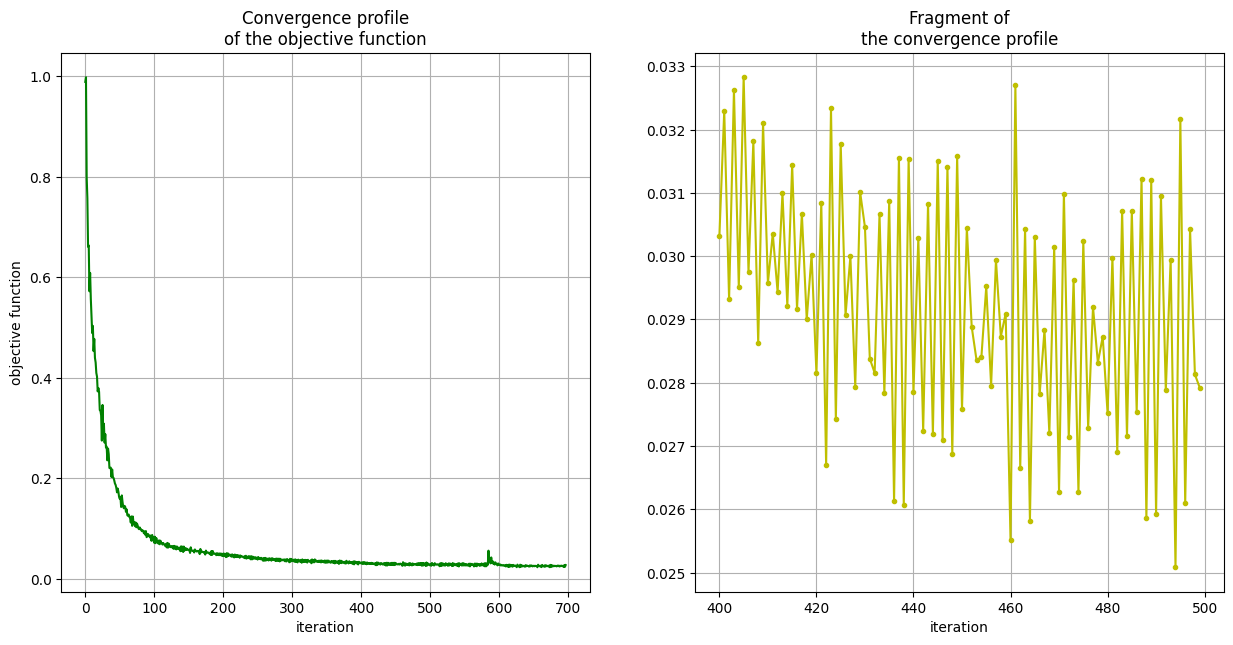

In [6]:
import matplotlib.pyplot as plt
best_no = int(0)
fobj = data["sorted_results"][best_no]["stats"]["convergence_profile"]
iters = list(range(len(fobj)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.set_ylabel("objective function")
ax1.set_xlabel("iteration")
ax1.grid()
ax1.set_title(f"Convergence profile\nof the objective function")
ax1.plot(iters, fobj, "g-")
ax2.set_xlabel("iteration")
ax2.grid()
ax2.set_title(f"Fragment of\nthe convergence profile")
imax = min(500, len(fobj))
imin = max(imax - 100, 0)
ax2.plot(iters[imin:imax], fobj[imin:imax], "y.-")

# References

1. L. Madden, and A. Simonetto, "Best approximate quantum compiling problems," ACM Transactions on Quantum Computing, vol.3, no.2, pp.1-29, 2022, https://arxiv.org/pdf/2106.05649.pdf
2. L. Madden, A. Akhriev and A. Simonetto, "Sketching the Best Approximate Quantum Compiling Problem," 2022 IEEE International Conference on Quantum Computing and Engineering (QCE), https://arxiv.org/abs/2205.04025
3. S. Khatri, R. LaRose, A. Poremba, L. Cincio, A.T. Sornborger, and P.J. Coles, "Quantum-assisted quantum compiling," Quantum, vol. 3, p. 140, 2019.
4. N. Halko, P.G. Martinsson, J. Tropp, "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions," SIAM Review, 53(2), 2011, https://arxiv.org/abs/0909.4061